In [1]:
%load_ext autoreload
%autoreload

import os, sys

modules = os.path.abspath(os.path.join("..", "src"))
sys.path.append(modules)

import polars as pl
from transformers import AutoModel, AutoTokenizer
import nlp_utils, keywords_utils, load_utils, run_analysis
from config import *

/home/msalvetti/notebooks_2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-28 14:00:14.728652: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Load the data**

In [2]:
data = pl.read_parquet("../data/processed/panel_all_data.parquet")

### Functions

#### Data manipulation

In [4]:
from typing import Literal
_TYPES = Literal["web", "pat"]

def get_data(type_: _TYPES = "web", canton = None, exclude_canton = None, df = data):
    if canton is not None:
        df = df.filter(pl.col("Canton") == canton)

    if exclude_canton is not None:
        df = df.filter(pl.col("Canton") != exclude_canton)
    
    if type_ == "web":
        df = df.select("ID", "cat_web", "n_kw_web", "n_unique_kw_web").explode("cat_web", "n_kw_web", "n_unique_kw_web")
    elif type_ == "pat":
        df = df.select("ID", "cat_pat", "n_kw_pat", "n_unique_kw_pat").explode("cat_pat", "n_kw_pat", "n_unique_kw_pat")
    else: 
        print("Error, choose web or patent")
        return 
    return df
    

def get_categories_percent(df: pl.DataFrame, type_: _TYPES = "web", thresh = None) -> pl.DataFrame:
    n_companies = df.select(pl.len()).item()
    if thresh != None:
        df = df.filter(pl.col("n_unique_kw_" + type_) >= thresh)
    df = df.group_by('cat_'+type_).agg(percent = pl.len() / n_companies)
    return df

def get_rta(ch: pl.DataFrame, canton: pl.DataFrame, type_: _TYPES = "web"):
    """
    Returns the ratio between the percents of companies active in a category and the log of the ratio.
    The ratio is percent_canton / percent_ch so ratio > 1 (or rta > 0) means that the canton is more 
    densely active in that sector compared to the rest of Switzerland
    """
    data = ch.join(canton, on = "cat_" + type_, how = "inner").fill_null(0)
    data = data.with_columns(ratio = pl.col("percent_right")/ pl.col("percent"))
    data = data.with_columns(log_rta = pl.col("ratio").log10())
    data = data.sort('log_rta')
    return data

def get_n_matches(df: pl.DataFrame, thresh: int, type_: _TYPES = "web"):
    return df.filter(pl.col("n_kw_"+type_)>= thresh).group_by('cat_'+type_).agg(pl.len().alias("n_companies"))

def get_n_unique_matches(df: pl.DataFrame, thresh: int, type_: _TYPES = "web"):
    return df.filter(pl.col("n_unique_kw_"+type_)>= thresh).group_by('cat_'+type_).agg(pl.len().alias("n_companies"))

def perform_multiple_thresholds(df: pl.DataFrame, threshs:list[int], func, **kwargs):
    result = []
    for t in threshs: 
        result.append(func(df, thresh = t, **kwargs))
    return result

def get_matches_by_cat(df: pl.DataFrame, thresh: int, type_ : _TYPES = "web"):
    return df.filter(pl.col("n_kw_"+type_)>=thresh).group_by("cat_"+type_, "n_kw_" + type_).agg(pl.len().alias("n_firms"))

def get_unique_matches_by_cat(df: pl.DataFrame, thresh: int, type_ : _TYPES = "web"):
    return df.filter(pl.col("n_unique_kw_"+type_)>=thresh).group_by("cat_"+type_, "n_unique_kw_" + type_).agg(pl.len().alias("n_firms"))

def get_survival_data(df: pl.DataFrame, type_:_TYPES="web"):
    return df.group_by("cat_"+type_, "n_kw_"+type_).agg(pl.len().alias("n_companies")).sort("n_companies", descending=True).fill_null("No category").fill_null(0)

def get_unique_survival_data(df: pl.DataFrame, type_:_TYPES="web"):
    return df.group_by("cat_"+type_, "n_unique_kw_"+type_).agg(pl.len().alias("n_companies")).sort("n_companies", descending=True).fill_null("No category").fill_null(0)

#### Plotting

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def plot_rta(plot_data: pl.DataFrame, type_: _TYPES="web", ax = None):
    diff = plot_data["log_rta"].to_list()
    cat = plot_data["cat_"+type_].to_list()

    if ax is None:
        fig = plt.figure(figsize=(6,12))
        ax = plt.subplot()

    y_pos = np.arange(len(cat))

    ax.barh(y_pos, diff, align="center")
    ax.set_yticks(y_pos, labels=cat)
    ax.set_ylim(-1, len(cat)+1)
    min_rta = plot_data["log_rta"].min()
    max_rta = plot_data["log_rta"].max()
    x_ticks = [min_rta, min_rta / 2, 0, max_rta / 2, max_rta]
    x_labels = [f"{10**xt:.1f}x" for xt in x_ticks]
    # x_labels = ["-80%", "-40%", "0%", "+50%", "+100%"]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)

In [7]:
def plot_grouped_bars(plot_data, ts, ax = None):

    res = plot_data[0]
    for i in range(1, len(plot_data)):
        res = res.join(plot_data[i], on = "cat_web", suffix = f"_{i}", how = 'full')
    res = res.fill_null(0).sort("n_companies", descending = True)
    values = [res["n_companies"].to_list(), res["n_companies_1"].to_list(), res["n_companies_2"].to_list()]

    cats = res['cat_web'].to_list()

    w, x = 0.25, np.arange(len(cats))
    if ax is None:
        fig, ax = plt.subplots(figsize = (12,6))

    ax.bar(x - w, values[0], width = w, label = f"Threshold = {ts[0]}")
    ax.bar(x, values[1], width = w, label = f"Threshold = {ts[1]}")
    ax.bar(x + w, values[2], width = w, label = f"Threshold = {ts[2]}")
    ax.set_xlim(-1)
    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation = 90)
    
    ax.set_title("Number of matching companied using n unique keywords")
    ax.set_xlabel("Category")
    ax.set_ylabel("Number of companies")

    plt.grid(axis="y", alpha = 0.5)
    plt.legend()


In [42]:
def plot_horizontal_bars(plot_data, x_col: str, y_col: str, geo: str, t: int, ax = None):

    """
    Plots horizontal bars.
    Args:
        plot_data (pl.DataFrame): data
        x_col (str): Column with quantities
        y_col (str): Column with categories
        geo (str): Geographic area (for text)
        t (int): Number of unique kws
    """

    if ax is None:
        fig, ax = plt.subplots(figsize = (6, 12))
    
    ax.barh(width = plot_data[x_col], y = plot_data[y_col])
    ax.set_xlabel("Number of companies")
    ax.set_ylabel("Category")
    ax.set_title(f"Number of companies active in each category in {geo}\n {t} or more unique keywords")

In [35]:
w = get_data()
w.filter(pl.col("n_unique_kw_web")>=1).group_by("cat_web").agg(pl.len())

ts = [1, 3, 5]
plot_data = perform_multiple_thresholds(get_data(), ts, get_n_unique_matches)
plot_data;

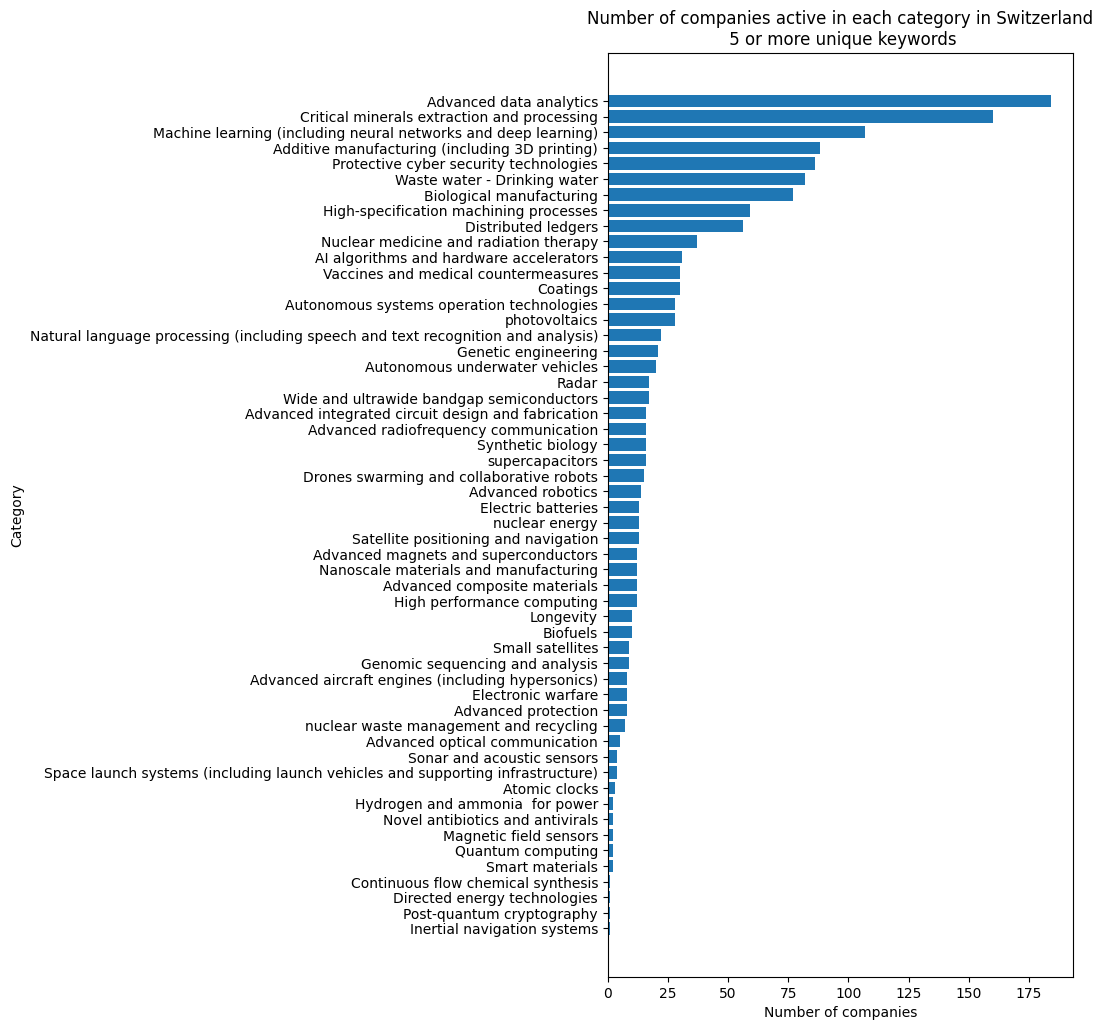

In [61]:
canton = "Switzerland"
t = 5
plot_horizontal_bars(get_n_unique_matches(get_data(), t).sort("n_companies"), x_col="n_companies", y_col = "cat_web", geo=canton, t = t)
plt.savefig(f"/home/msalvetti/Desktop/plots/{canton}_{t}.png", bbox_inches='tight')

### Plots

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("style.mplstyle")

cmap = mpl.colormaps["Set2"]
colors = cmap([0,1,2])

Text(0.5, 1.0, 'Number of matching companies using n unique keywords - Lucerne')

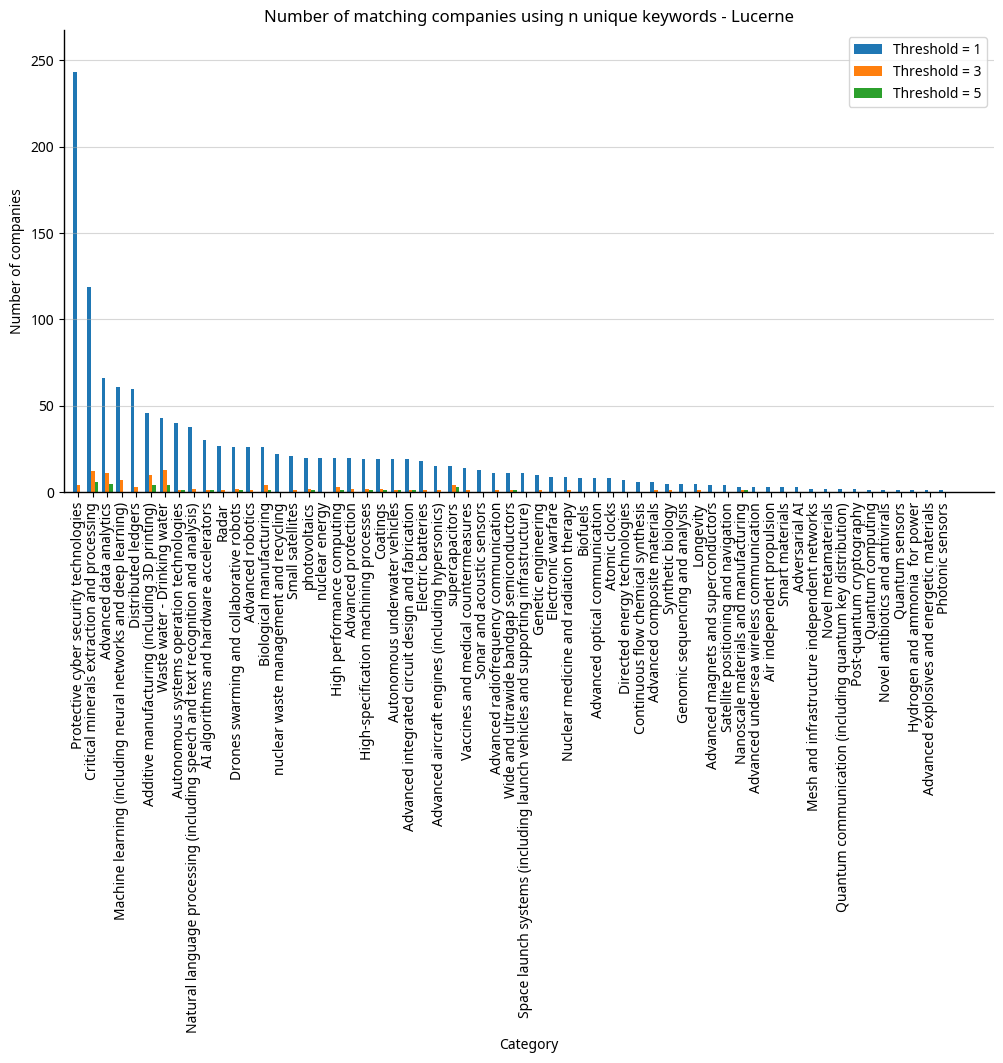

In [47]:
ts = [1, 3, 5]
plot_data = perform_multiple_thresholds(get_data(canton="Lucerne"), ts, get_n_unique_matches)
fig, ax = plt.subplots(figsize = (12,6))
plot_grouped_bars(plot_data, ts, ax)
ax.set_title("Number of matching companies using n unique keywords - Lucerne")


# ts = [10, 30, 50]
# plot_data2 = perform_multiple_thresholds(get_data(), ts, get_matches_by_cat)
# plot_grouped_bars(plot_data2, ts)

In [63]:
run = pl.scan_parquet("../data/cleaned/run*/*.parquet").select("ID", "url").group_by("ID").agg(pl.col("url").first())
data_lucerne_web.filter(pl.col("cat_web") == "High performance computing").lazy().join(run, on = "ID").collect().filter(pl.col("n_unique_kw_web")>=3).sort("n_unique_kw_web")
# data_lucerne_web.filter(pl.col("cat_web") == "supercapacitors").lazy().join(run, on = "ID").collect().filter(pl.col("n_unique_kw_web")>=3).sort("n_unique_kw_web")

ID,cat_web,n_kw_web,n_unique_kw_web,url
str,str,u32,u32,str
"""CH10030164414""","""High performance computing""",14,3,"""https://zeitag.ch"""
"""CHCHE109906568""","""High performance computing""",14,3,"""https://zeitag.ch"""
"""CHCHE313967551""","""High performance computing""",181,14,"""https://www.dalco.ch/"""


Text(0.5, 1.0, 'Category analysis, threshold = 5')

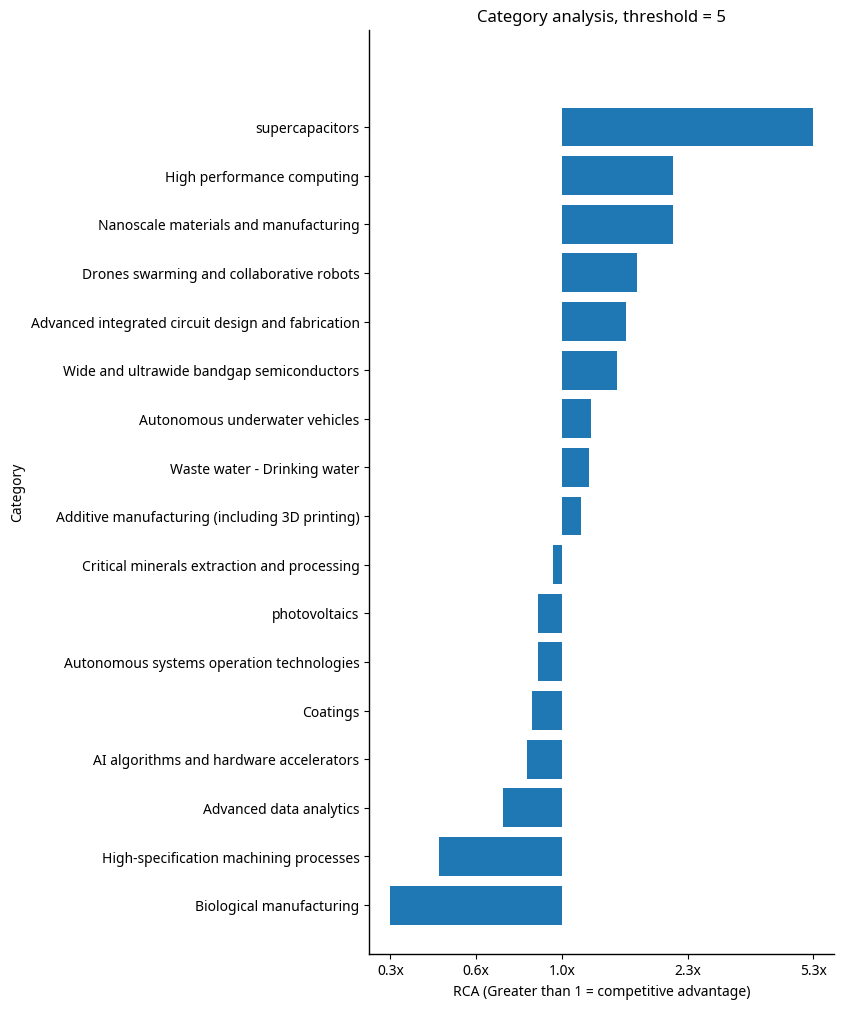

In [56]:
data_web = get_data(exclude_canton="Lucerne")
data_lucerne_web = get_data(canton="Lucerne")

t = [3, 5]
percent_web = perform_multiple_thresholds(data_web, t, get_categories_percent)
percent_web_lucerne = perform_multiple_thresholds(data_lucerne_web, t, get_categories_percent)

compare = []
for i in range(0, len(percent_web)):
    compare.append(get_rta(percent_web[i], percent_web_lucerne[i]))

fig, ax = plt.subplots(figsize = (6, 12))
# plot_rta(compare[0], ax = ax)
plot_rta(compare[1], ax = ax)
ax.set_ylabel("Category")
ax.set_xlabel("RCA (Greater than 1 = competitive advantage)")
# ax.set_title("RCA analysis - Lucerne/Switzerland - threshold = 3")
ax.set_title("Category analysis, threshold = 5")


In [ ]:
ch_per_web = get_categories_percent(get_data(), thresh=3).rename({"cat_web": "category", "percent": "percent_web"})
ch_per_pat = get_categories_percent(get_data(type_= "pat"), type_="pat", thresh=3).rename({"cat_pat": "category", "percent": "percent_pat"})
per_df = ch_per_web.join(ch_per_pat, on = "category")

cat_web,len
str,u32
null,3895


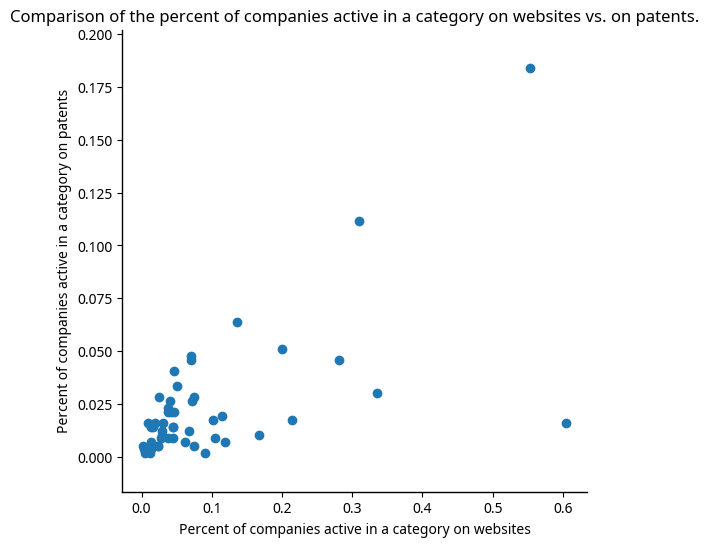

In [24]:
fig, ax = plt.subplots(figsize = (6,6))
ax.set_xlabel("Percent of companies active in a category on websites")
ax.set_ylabel("Percent of companies active in a category on patents")
ax.set_title("Comparison of the percent of companies active in a category on websites vs. on patents.")
plt.scatter(per_df["percent_web"]*100, per_df["percent_pat"]*100)

In [10]:
ch_web = get_data()
ch_web.group_by("")

Number of companies with 1 ukw vs 3

(-1000.0, 45163.7)

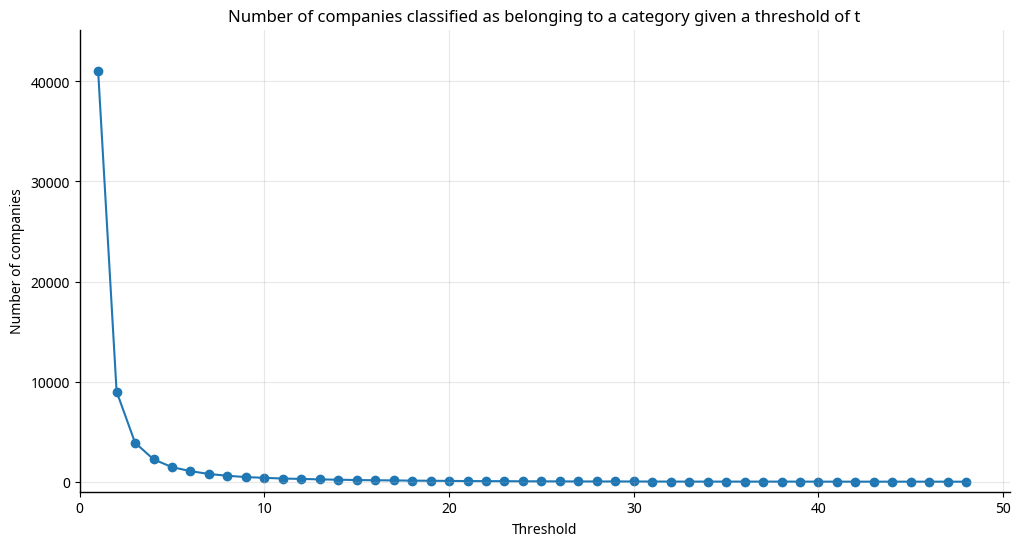

In [11]:
t = range(1, 49)
plot_data = [get_n_unique_matches(ch_web, i).sum()["n_companies"].item() for i in t]

fig, ax = plt.subplots(figsize = (12, 6))
plt.scatter(x = list(t), y = plot_data)
plt.plot(list(t), plot_data)

ax.set_title("Number of companies classified as belonging to a category given a threshold of t")
ax.set_ylabel("Number of companies")
ax.set_xlabel("Threshold")
ax.set_xlim(0)
ax.grid(alpha = 0.3)
ax.set_ylim(-1000)

In [14]:
plot_data[2]/plot_data[0]

0.09486579960056506

Compare patents and web

In [130]:
ch_web = get_data()
ch_pat = get_data(type_= "pat")
n_web = ch_web.select(pl.len())
n_pat = ch_pat.select(pl.len())
per_ch_web3 = get_n_unique_matches(ch_web, thresh=3).with_columns(
    pl.col("n_companies") / n_web.item()
    ).rename({"cat_web": "cat"})
per_ch_pat3 = get_n_unique_matches(ch_pat, type_="pat", thresh=3).with_columns(
    pl.col("n_companies") / n_pat.item()
    ).rename({"cat_pat": "cat"})
merge = per_ch_web3.join(per_ch_pat3, on = "cat", suffix = "_pat")

In [142]:
merge.sort("n_companies")

cat,n_companies,n_companies_pat
str,f64,f64
"""Advanced explosives and energe…",0.000025,0.000053
"""Magnetic field sensors""",0.000038,0.000035
"""Photonic sensors""",0.000051,0.000018
"""Smart materials""",0.000089,0.000159
"""Hydrogen and ammonia for powe…",0.000114,0.000018
…,…,…
"""Waste water - Drinking water""",0.002813,0.000459
"""Additive manufacturing (includ…",0.003092,0.001113
"""Machine learning (including ne…",0.003358,0.0003


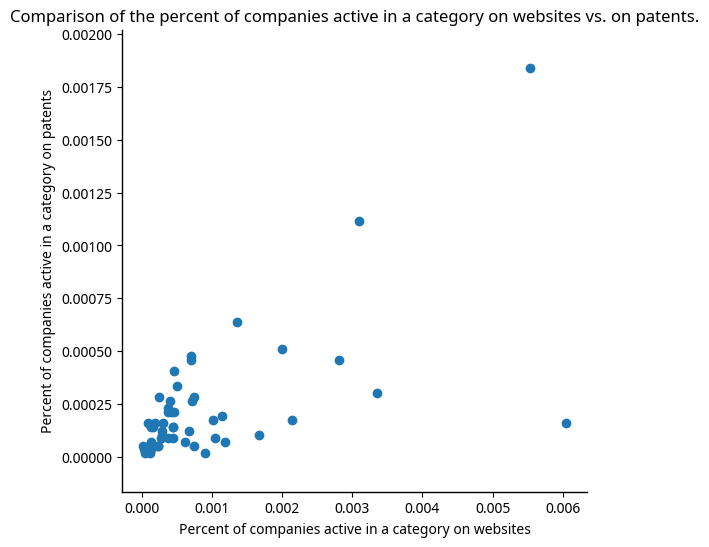

In [139]:
fig, ax = plt.subplots(figsize = (6,6))
ax.set_xlabel("Percent of companies active in a category on websites")
ax.set_ylabel("Percent of companies active in a category on patents")
ax.set_title("Comparison of the percent of companies active in a category on websites vs. on patents.")
plt.scatter(per_web, per_pat)

In [239]:
merge

cat,n_companies,n_companies_pat
str,f64,f64
"""Wide and ultrawide bandgap sem…",0.000469,0.000212
"""Advanced robotics""",0.000722,0.000265
"""Advanced composite materials""",0.000304,0.000159
"""Advanced aircraft engines (inc…",0.00019,0.000159
"""Small satellites""",0.00038,0.000212
…,…,…
"""Autonomous underwater vehicles""",0.000748,0.000283
"""Advanced integrated circuit de…",0.000444,0.000141
"""Hydrogen and ammonia for powe…",0.000114,0.000018


In [226]:
lu = get_data(canton="Lucerne")
ch = get_data()
lu_abs = get_n_unique_matches(lu, thresh=3).select("cat_web", "n_companies").rename({"n_companies": "Number of firms"})
lu_per = get_categories_percent(lu, thresh=3).rename({"percent": "Percent"})
lu_rta = get_rta(get_categories_percent(ch, thresh=3), get_categories_percent(lu, thresh=3)).select("cat_web", "ratio").sort("ratio", descending=True).rename({"ratio": "Ratio"})

In [227]:
res = lu_abs.join(lu_per, on = "cat_web", how = "full").rename({"cat_web_right": "cat_web2"}).join(lu_rta, on = "cat_web", how = "full")

In [228]:
res

cat_web,Number of firms,cat_web2,Percent,cat_web_right,Ratio
str,u32,str,f64,str,f64
"""supercapacitors""",4,"""supercapacitors""",0.001239,"""supercapacitors""",2.642922
"""High performance computing""",3,"""High performance computing""",0.000929,"""High performance computing""",2.157091
"""Advanced aircraft engines (inc…",1,"""Advanced aircraft engines (inc…",0.00031,"""Advanced aircraft engines (inc…",1.629802
"""Waste water - Drinking water""",13,"""Waste water - Drinking water""",0.004027,"""Waste water - Drinking water""",1.431583
"""Advanced protection""",2,"""Advanced protection""",0.00062,"""Advanced protection""",1.396973
…,…,…,…,…,…
"""High-specification machining p…",2,"""High-specification machining p…",0.00062,"""High-specification machining p…",0.370409
"""Vaccines and medical counterme…",1,"""Vaccines and medical counterme…",0.00031,"""Vaccines and medical counterme…",0.305588
"""Nuclear medicine and radiation…",1,"""Nuclear medicine and radiation…",0.00031,"""Nuclear medicine and radiation…",0.298134


In [232]:
res =res.with_columns(
    pl.when(pl.col("cat_web").is_not_null()).then((pl.col("cat_web")))
    .otherwise("cat_web_right")
).with_columns(
    pl.when(pl.col("cat_web").is_not_null()).then((pl.col("cat_web")))
    .otherwise("cat_web2")
).drop("cat_web2", "cat_web_right").sort("Ratio", descending=True)

In [237]:
res.rename({"cat_web": "Category"}).to_pandas()

,Category,Number of firms,Percent,Ratio
0,supercapacitors,4,0.001239,2.642922
1,High performance computing,3,0.000929,2.157091
2,Advanced aircraft engines (including hypersonics),1,0.000310,1.629802
3,Waste water - Drinking water,13,0.004027,1.431583
4,Advanced protection,2,0.000620,1.396973
5,Nanoscale materials and manufacturing,1,0.000310,1.062914
6,Advanced composite materials,1,0.000310,1.018626
7,Additive manufacturing (including 3D printing),10,0.003098,1.001927
8,Drones swarming and collaborative robots,2,0.000620,0.922529
9,photovoltaics,2,0.000620,0.873108
